Using Colab cache for faster access to the 'brain-tumor-classification-mri' dataset.
Path to dataset files: /kaggle/input/brain-tumor-classification-mri
Epoch: 1/25, Loss: 1.33916 
Epoch: 2/25, Loss: 1.19679 
Epoch: 3/25, Loss: 1.08432 
Epoch: 4/25, Loss: 1.00215 
Epoch: 5/25, Loss: 0.93382 
Epoch: 6/25, Loss: 0.87038 
Epoch: 7/25, Loss: 0.80389 
Epoch: 8/25, Loss: 0.74781 
Epoch: 9/25, Loss: 0.72439 
Epoch: 10/25, Loss: 0.69560 
Epoch: 11/25, Loss: 0.65762 
Epoch: 12/25, Loss: 0.65170 
Epoch: 13/25, Loss: 0.64449 
Epoch: 14/25, Loss: 0.63187 
Epoch: 15/25, Loss: 0.59884 
Epoch: 16/25, Loss: 0.58477 
Epoch: 17/25, Loss: 0.54823 
Epoch: 18/25, Loss: 0.54674 
Epoch: 19/25, Loss: 0.52560 
Epoch: 20/25, Loss: 0.50629 
Epoch: 21/25, Loss: 0.48000 
Epoch: 22/25, Loss: 0.47729 
Epoch: 23/25, Loss: 0.44707 
Epoch: 24/25, Loss: 0.42536 
Epoch: 25/25, Loss: 0.42095 


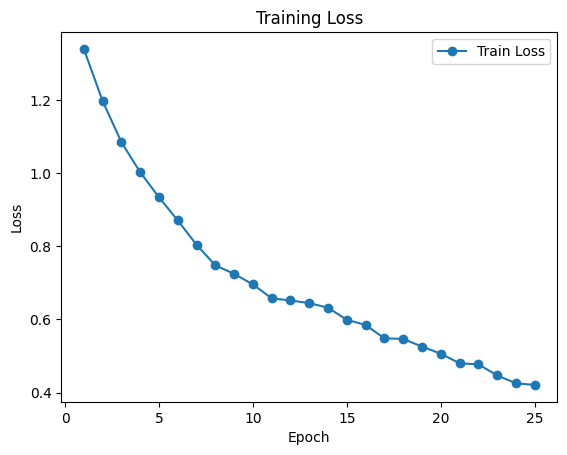

Test accuracy: 53.2994923857868 %

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.48      0.16      0.24       100
meningioma_tumor       0.62      0.57      0.59       115
        no_tumor       0.45      0.82      0.58       105
 pituitary_tumor       0.69      0.57      0.62        74

        accuracy                           0.53       394
       macro avg       0.56      0.53      0.51       394
    weighted avg       0.55      0.53      0.51       394

Macro F1: 0.5086498821574766


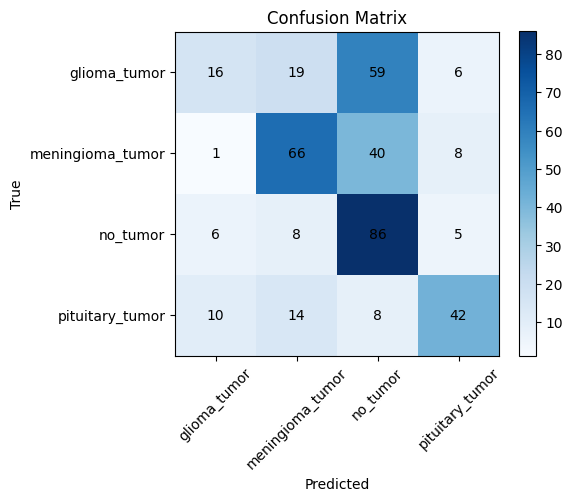


Per-class accuracy:
glioma_tumor: 0.1600
meningioma_tumor: 0.5739
no_tumor: 0.8190
pituitary_tumor: 0.5676


In [2]:
from matplotlib.lines import lineStyles
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sartajbhuvaji/brain-tumor-classification-mri")

print("Path to dataset files:", path)

# libery
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder # klasörlerden otomatik etiket okur
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import os
import random

import cv2
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report, f1_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def mr_veri_cv2(img_bgr , img_size = 224,
                use_clahe=True, use_blur=False,
                normalize_mode = "minmax"):

  img_bgr = cv2.resize(img_bgr, (img_size,img_size),interpolation=cv2.INTER_AREA ) # aynı boyut
  img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) # mr mantığında griye çeviriyoruz

  if use_clahe:
    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize=(8,8))
    img_gray = clahe.apply(img_gray)

  if use_blur:
    img_gray = cv2.GaussianBlur(img_gray, (3,3),0)

  img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB) # görüntüler 3 kanallı
  img = cv2.normalize(img_rgb, None, 0, 255, cv2.NORM_MINMAX)
  img = img.astype(np.float32) / 255.0
  return img

class OpenCV_Prepprocess: # ımagefolder a transform baglayan sınıf
  def __init__(self, img_size=224, use_clahe=True, use_blur=False):
    self.img_size = img_size
    self.use_clahe = use_clahe
    self.use_blur = use_blur

  def __call__(self,pil_img: Image.Image):
    img_rgb = np.array(pil_img)
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)

    img = mr_veri_cv2(img_bgr, img_size= self.img_size,
                      use_clahe = self.use_clahe, use_blur=self.use_blur)

    img = np.transpose(img, (2,0,1))
    img = torch.from_numpy(img).float()
    return img

DATASET_PATH = "/root/.cache/kagglehub/datasets/sartajbhuvaji/brain-tumor-classification-mri/versions/3"


# load dataset
def get_data_loaders(batch_size=64, img_size=224): # her iterasyonda işlenecek veri sayisi
  transform = OpenCV_Prepprocess(img_size=img_size, use_clahe=True, use_blur=False)

  # eğitim ve test verisi
  train_set = ImageFolder(
    root=os.path.join(DATASET_PATH, "Training"),
    transform=transform
)
  test_set = ImageFolder(
    root=os.path.join(DATASET_PATH, "Testing"),
    transform=transform
)

  # verileri yukle
  train_loader = torch.utils.data.DataLoader(train_set , batch_size = batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle=False )

  class_names = train_set.classes
  return train_loader, test_loader, class_names

# visiualize dataset

# build cnn
class CNN(nn.Module):
  def __init__(self,num_classes):
    super(CNN, self).__init__() # modelin iç yapısını tanıtır
    self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size=3, padding=1) # in_channels = kaç kanal , our_channels_filtre sayısı(kaç özellik çıkartılacak), kernel_size(filtre/pencere boyutu), padding(kenarları koruma)
    self.relu = nn.ReLU() # aktivasyon kodumuz
    self.pool = nn.MaxPool2d(kernel_size = 2, stride=2) # 2x2 boyutunda pooling katmanı
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1) # 64 filtreli ikinci convolusion katmanı
    self.dropout = nn.Dropout(0.2)
    self.fc1 = nn.Linear(64*16*16, 128) # fully connected layer giris = 4096, output = 128
    self.fc2 = nn.Linear(128, num_classes)
 # output katmanı

    # img 3x3x32 --> conv(32) -> relu(32) -> pool(16)
    # conv(16) -> relu(16) -> pool(8) -> img(8x8)
  def forward(self,x):
     x = self.pool(self.relu(self.conv1(x)))
     x = self.pool(self.relu(self.conv2(x)))
     x = x.view(x.size(0), -1)
     x = self.dropout(self.relu(self.fc1(x)))
     x = self.fc2(x)
     return x
# define loss fonction and optimizer
define_loss_and_optimizer = lambda model:(
    nn.CrossEntropyLoss(),
    optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9) #stochasric gradient descent ,  momentum: optimizer ın geçmiş adımlarının hız kazanmasını sağlar, zigzagları azaltır
)


# training
def train_model(model, train_loader, criterion, optimizer, epochs = 5):
  model.train() # modelimizi eğitim moduna alalım
  train_losses = [] # loss değerlerini saklamak için bir liste
  for epoch in range(epochs): # belirtilen epoch sayısı kadar döngü
    total_loss = 0  # toplam loss değerlerini saklıyoruz
    for images, labels in train_loader:
      images, labels = images.to(device) , labels.to(device) # tum egitim veri setini taramak için

      optimizer.zero_grad() # graduanları sıfırla
      outputs = model(images) # forward propagation (predivtion)
      loss = criterion(outputs, labels) # loss değerini hesaplama
      loss.backward() # geri yayılım
      optimizer.step() # ogrenme

      total_loss += loss.item()

    avg_loss = total_loss / len(train_loader) # ortalama kayıp hesaplama
    train_losses.append(avg_loss)
    print(f"Epoch: {epoch+1}/{epochs}, Loss: {avg_loss:.5f} ")
  return train_losses


# test
def test_model(model, test_loader):
  model.eval()
  correct = 0
  total =0

  with torch.no_grad(): # gradyan hesaplamasini kapat
    for images, labels in test_loader: # test veri setinden değerlendirme
      images, labels = images.to(device) , labels.to(device) # verileri cihaza taşı

      outputs = model(images) # predivtion
      _, predicted = torch.max(outputs,1) # en yuksek etiketli sinifi al
      total += labels.size(0) # toplam veri sayisi
      correct += (predicted == labels).sum().item() # doğru tahminleri say
  print(f"Test accuracy: {100 * correct / total} %") # dogruluk oranını yazdır

train_loader, test_loader, class_names = get_data_loaders(batch_size=32, img_size=64)

model = CNN(num_classes=len(class_names)).to(device)
criterion, optimizer = define_loss_and_optimizer(model)

train_losses = train_model(model, train_loader, criterion, optimizer, epochs=25)

plt.figure()
plt.plot(range(1, len(train_losses)+1), train_losses, marker="o", label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss")
plt.legend(); plt.show()

test_model(model, test_loader)

# rapor ve matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# --- Classification report + F1 ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Macro F1:", f1_score(y_true, y_pred, average="macro"))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- Her sınıfın doğruluğu ---
per_class_acc = np.divide(
    cm.diagonal(),
    cm.sum(axis=1),
    out=np.zeros(len(class_names)),
    where=cm.sum(axis=1) != 0
)

print("\nPer-class accuracy:")
for i, name in enumerate(class_names):
    print(f"{name}: {per_class_acc[i]:.4f}")

